# Conv-GAIN
<!-- # Build Conv-GAIN
Impute missing values in data_x

Args:
- data_x: original data with missing values
- gain_parameters: GAIN network parameters:
  - batch_size: Batch size
  - hint_rate: Hint rate
  - alpha: Hyperparameter
  - iterations: Iterations

Returns:
- imputed_data: imputed data 
<h4 align="center">Conv-GAIN architecture</h4>
<img src='Conv_GAIN.png'></img>

<h4 align="center">The Proposed Conv-GAIN architecture</h4>
<img src="Conv_GAIN_layers.png" align="left"></img> -->

In [2]:
from conv_gain_utils import *
from tqdm import tqdm 
import numpy as np
from keras.datasets import mnist
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as  plt

Instructions for updating:
non-resource variables are not supported in the long term


In [1]:
def Conv_GAIN(miss_data_x, conv_gain_parameters):
    
    # Define mask matrix
    data_m = 1-np.isnan(miss_data_x)

    # System parameters
    batch_size = conv_gain_parameters['batch_size']
    hint_rate = conv_gain_parameters['hint_rate']
    alpha = conv_gain_parameters['alpha']
    iterations = conv_gain_parameters['iterations']
    learning_rate = conv_gain_parameters['learning_rate']

    # Other parameters
    no, rows, cols, _ = miss_data_x.shape

    # Hidden state dimensions
    h_dim = (rows, cols, 1)

    # Normalization
    norm_data, norm_parameters = normalization(miss_data_x)
    norm_data_x = np.nan_to_num(norm_data, 0)

    # Reset the default graph
    tf.reset_default_graph()

    ## GAIN architecture   
    # Input placeholders
    # Data vector
    X = tf.placeholder(tf.float32, shape = [None, rows, cols, 1])
    # Mask vector
    M = tf.placeholder(tf.float32, shape = [None, rows, cols, 1])
    # Hint vector
    H = tf.placeholder(tf.float32, shape = [None, rows, cols, 1])
    # Noise vector
    Z = tf.placeholder(tf.float32, shape = [None, rows, cols, 1])

    # D Weights and Biases
    D_weights = {
        # Convolution Layers
        'c1': tf.Variable(xavier_init((3,3,1,32)), name='W1'), 
        'c2': tf.Variable(xavier_init((3,3,32,64)), name='W2'),

        # Dense Layers
        'd1': tf.Variable(xavier_init((6272,1024)), name='W3'),
    #     'd2': tf.Variable(xavier_init((1024,1024)), name='W4'),
        'out': tf.Variable(xavier_init((1024,784)), name='W4'), 
    }
    D_biases = {
        # Convolution Layers
        'c1': tf.Variable(xavier_init((32,)), name='B1'),
        'c2': tf.Variable(xavier_init((64,)), name='B2'),

        # Dense Layers
        'd1': tf.Variable(xavier_init((1024,)), name='B3'),
    #     'd2': tf.Variable(xavier_init((1024,)), name='B4'),
        'out': tf.Variable(xavier_init((784,)), name='B4'),
    }

    theta_D = np.concatenate(list((list(D_weights.values()), list(D_biases.values()))))

    # G Weights and Biases
    G_weights = {
        # Convolution Layers
        'c1': tf.Variable(xavier_init((3,3,1,32)), name='W1'), 
        'c2': tf.Variable(xavier_init((3,3,32,64)), name='W2'),

        # Dense Layers
        'd1': tf.Variable(xavier_init((9408,1024)), name='W3'), # 7*14*64 = 6272
    #     'd2': tf.Variable(xavier_init((1024,1024)), name='W4'),
        'out': tf.Variable(xavier_init((1024,784)), name='W4'), 
    }
    G_biases = {
        # Convolution Layers
        'c1': tf.Variable(xavier_init((32,)), name='B1'),
        'c2': tf.Variable(xavier_init((64,)), name='B2'),

        # Dense Layers
        'd1': tf.Variable(xavier_init((1024,)), name='B3'),
    #     'd2': tf.Variable(xavier_init((1024,)), name='B4'),
        'out': tf.Variable(xavier_init((784,)), name='B4'),
    }

    theta_G = np.concatenate(list((list(G_weights.values()), list(G_biases.values()))))

    # 2D Convolutional Function
    def conv2d(x, W, b, strides=1):
        x = tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')
        x = tf.nn.bias_add(x, b)
        x = tf.nn.relu(x)
        return x

    def generator(x, m, z):
        # Concatenate Mask and Data
        inputs = tf.concat(values = [x, m, z], axis = 1)
    #         inputs = tf.where(tf.is_nan(inputs), tf.zeros_like(inputs), inputs)
        # Convolution layers
        #First Layer
        conv1 = conv2d(inputs, G_weights['c1'], G_biases['c1']) # [28,84,1] ==> [26,84,32]
        pool1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') # [28,84,32] ==> [14,42,32]
    #                 norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)
        #Second Layer
        conv2 = conv2d(pool1, G_weights['c2'], G_biases['c2']) # [14,42,32] ==> [14,42,64]
        pool2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') # [14,42,64] ==> [7,21,64]
        # Flatten Layer
        flat = tf.reshape(pool2, [-1, G_weights['d1'].get_shape().as_list()[0]]) # [7*21*64] = [9408]
        # Fully connected layer
        fc1 = tf.nn.relu(tf.add(tf.matmul(flat, G_weights['d1']), G_biases['d1'])) # [1204]
    #     fc2 = tf.nn.relu(tf.add(tf.matmul(fc1, G_weights['d2']), G_biases['d2'])) # [1204]
        # MinMax normalized output
        G_prob = tf.nn.sigmoid(tf.add(tf.matmul(fc1, G_weights['out']) , G_biases['out'])) # [728]
        G_prob = tf.reshape(G_prob, [-1, 28,28,1])
        return G_prob

    # Discriminator
    def discriminator(x, h):
        # Concatenate Mask and Data
        inputs = tf.concat(values = [x, h], axis = 1) 
        # Convolution layers
        #First Layer
        conv1 = conv2d(inputs, D_weights['c1'], D_biases['c1']) # [28,56,1] ==> [26,56,32]
        pool1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') # [28,56,32] ==> [14,28,32]
        #Second Layer
        conv2 = conv2d(pool1, D_weights['c2'], D_biases['c2']) # [14,28,32] ==> [14,28,64]
        pool2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') # [14,28,64] ==> [7,14,64]
        # Flatten Layer
        flat = tf.reshape(pool2, [-1, D_weights['d1'].get_shape().as_list()[0]]) # [7*7*64] = [6272]
        # Fully connected layer
        fc1 = tf.nn.relu(tf.add(tf.matmul(flat, D_weights['d1']), D_biases['d1'])) # [1204]
    #     fc2 = tf.nn.relu(tf.add(tf.matmul(fc1, D_weights['d2']), D_biases['d2'])) # [1204]
        # MinMax normalized output
        D_logit = tf.add(tf.matmul(fc1, D_weights['out']) ,D_biases['out']) # [728]
        D_prob = tf.nn.sigmoid(D_logit)
        D_prob = tf.reshape(D_prob, [-1, 28,28,1])
        return D_prob

    ## GAIN structure
    # Generator
    G_sample = generator(X, M, Z)

    # Combine with observed data(real obs + missed after generation)
    Hat_X = X * M + G_sample * (1-M)

    # Discriminator
    D_prob = discriminator(Hat_X, H)

    ## GAIN loss
    D_loss_temp = -tf.reduce_mean(M * tf.log(D_prob + 1e-8) + (1-M) * tf.log(1. - D_prob + 1e-8)) 

    G_loss_temp = -tf.reduce_mean((1-M) * tf.log(D_prob + 1e-8))

    MSE_loss = tf.reduce_mean((M * X - M * G_sample)**2) / tf.reduce_mean(M)

    D_loss = D_loss_temp
    G_loss = G_loss_temp + alpha * MSE_loss 

    ## GAIN solver
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(D_loss, var_list=theta_D.tolist())
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(G_loss, var_list=theta_G.tolist())

    # Start the session
    sess = tf.Session()
    # Initialize the global parameters 
    sess.run(tf.global_variables_initializer())

    # Start Iterations
    for epoch in range(iterations):
        prog_bar = tqdm(range(int(len(miss_data_x)/batch_size)))
        for step in prog_bar:  
            # Sample batch
            batch_idx = sample_batch_index(no, batch_size)
            X_mb = norm_data_x[batch_idx, :] 
            X_mb = np.reshape(X_mb, (-1, 28, 28, 1))
            M_mb = data_m[batch_idx, :]  
            M_mb = np.reshape(M_mb, (-1, 28, 28, 1))
            # Sample random vectors  
            Z_mb = uniform_sampler(0, 0.01, (batch_size, rows, cols, 1)) 
            Z_mb = np.reshape(Z_mb, (batch_size, rows, cols, 1))
            # Sample hint vectors
            H_mb_temp = binary_sampler(hint_rate, (1, rows, cols, 1))
            H_mb = M_mb * H_mb_temp
            # Combine random vectors with observed vectors
            X_mb = M_mb * X_mb + (1-M_mb) * Z_mb 
            Z_mb = np.reshape(Z_mb, X_mb.shape)
            _, D_loss_curr = sess.run([D_solver, D_loss_temp], 
                                      feed_dict = {M: M_mb, X: X_mb, H: H_mb, Z: Z_mb})

            _, G_loss_curr, MSE_loss_curr = sess.run([G_solver, G_loss_temp, MSE_loss],
                                                     feed_dict = {X: X_mb, M: M_mb, H: H_mb, Z: Z_mb})

            prog_bar.set_description("D_loss, G_loss: {:.3f}, {:.3f}".format(D_loss_curr, G_loss_curr))

    # Return imputed data     
    Z_mb = uniform_sampler(0, 0.01, (no, rows, cols, 1)) 
    Z_mb = np.reshape(Z_mb, (no, rows, cols, 1))
    M_mb = data_m
    M_mb = np.reshape(M_mb, (-1, 28, 28, 1))
    X_mb = norm_data_x     
    X_mb = np.reshape(X_mb, (-1, 28, 28, 1))
    X_mb = M_mb * X_mb + (1-M_mb) * Z_mb

    imputed_data = sess.run([G_sample], feed_dict = {X: X_mb[:1000], M: M_mb[:1000], Z:Z_mb[:1000]})[0]
    imputed_data = data_m[:1000] * norm_data_x[:1000] + (1-data_m[:1000]) * imputed_data

    # Renormalization
    imputed_data = renormalization(imputed_data, norm_parameters)  
    # Rounding
    imputed_data = rounding(imputed_data, data_x)
    
    # Save Model
    saver = tf.train.Saver() 
    saver.save(sess, './model.ckpt')
    
    return imputed_data

In [2]:

data_x, miss_data_x, data_m = data_loader(0.1)

conv_gain_parameters = {'batch_size':64,
                        'hint_rate':0.1,
                        'learning_rate':0.0001,
                        'alpha':0.005,
                        'iterations':1}

imputed_data = Conv_GAIN(miss_data_x, conv_gain_parameters)

NameError: name 'data_loader' is not defined

Image : 165


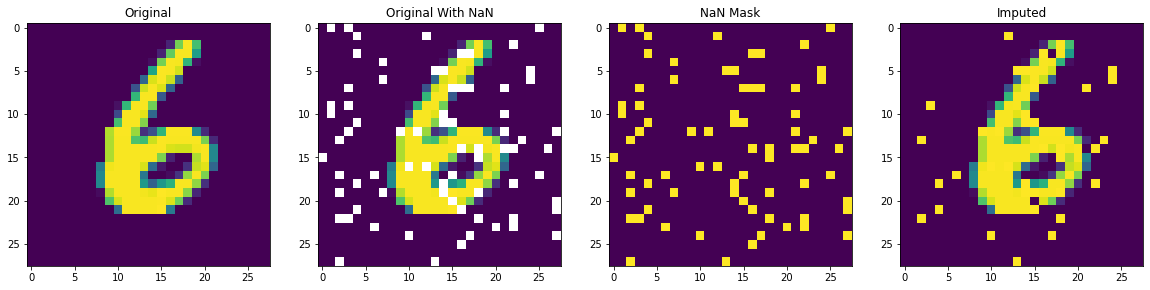

Image : 161


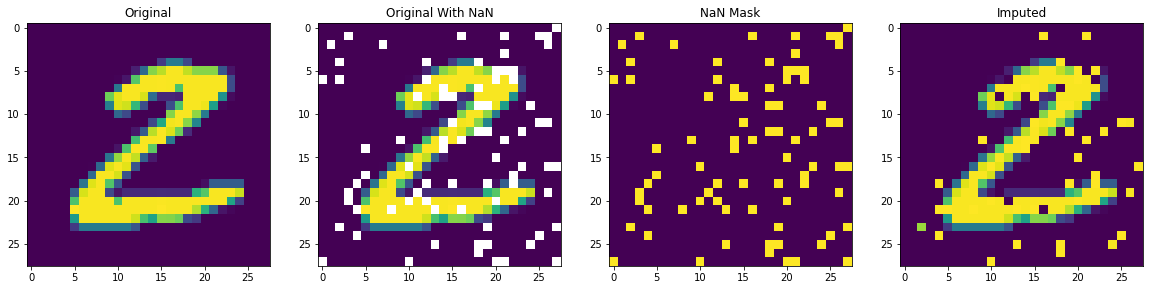

Image : 556


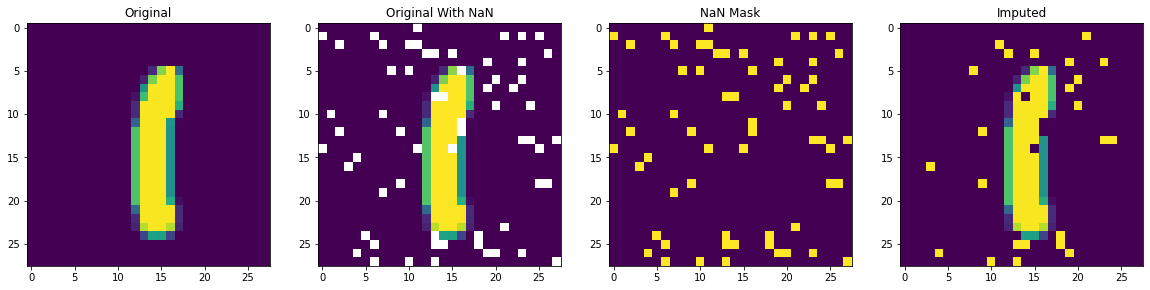

In [56]:
show_results(data_x, miss_data_x, data_m, imputed_data, num_examples=3)